# Feature Extraction Training Data

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
%matplotlib inline

In [3]:
os.getcwd()

'/Users/tilia/HZ/SmartCleanCityHackZurich19'

In [4]:
%cd data

/Users/tilia/HZ/SmartCleanCityHackZurich19/data


## Load the Files

In [5]:
pred_msr = pd.read_csv("./2019-09-27-basel-measures-prediction-cleaned.csv", sep=";") 

In [6]:
msr = pd.read_csv("./2019-09-27-basel-measures-cleaned.csv", sep=";") 

In [7]:
print(msr.shape)
msr.head()

(58242, 17)


,collection,suitcase_id,place_name,place_type,osm_id,cci_id,date,cci,rateCigarrettes,ratePapers,rateBottles,rateExcrements,rateSyringues,rateGums,rateLeaves,rateGrits,rateGlassDebris
0,places,49,Leimgrubenweg,bus_stop,1175332462,287,2019-04-01 8:40:49,3.20000,0.60000,1.2,0.0,0,0,0,0.00000,0,0.0
1,map_features,49,Leimgrubenweg,secondary,25149740,86_9668,2019-04-01 8:40:53,3.35764,0.44236,1.2,0.0,0,0,0,0.00000,0,0.0
2,map_features,49,Reinacherstrasse,primary,117485263,86_11641,2019-04-01 8:40:53,3.35764,0.44236,1.2,0.0,0,0,0,0.00000,0,0.0
3,places,49,Leimgrubenweg,bus_stop,2621172927,287,2019-04-01 8:40:57,3.19757,0.60000,1.2,0.0,0,0,0,0.00243,0,0.0
4,map_features,49,Dornacherstrasse,secondary,148833576,86_12436,2019-04-01 8:42:11,5.00000,0.00000,0.0,0.0,0,0,0,0.00000,0,0.0


## Select Relevant Columns

In [8]:
msr_features = msr[['osm_id', 'cci_id', 'date', 'place_name', 'place_type', 'cci']].copy()

## Exclude rubbish types that are not feasible for pedestrians and calculate a new score: p_cci (pedestrian cci)

In [9]:
exclude = ['rateGrits', 'rateExcrements', 'rateSyringes', 'rateGlassDebris']

relevant = msr[[c for c in msr.columns if c.startswith('rate') and c not in exclude]]

relevant = relevant.astype('float')

msr_features['cci_p'] = relevant.apply(lambda x: 5.0 - sum(x), axis=1)

## Add features from datetime: hour, day, weekday, month and year

In [10]:
import datetime

def get_datefeat(date_str):
    a = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    weekday = a.weekday()
    month = a.month
    day = a.day
    hour = a.hour
    year = a.year
    
    return (hour, day, weekday, month, year)

datefeat = pd.DataFrame.from_records(msr_features.date.apply(lambda x: get_datefeat(x)).tolist(), columns=['hour', 'day', 'weekday', 'month', 'year'])

msr_features = msr_features.join(datefeat)

msr_features.head()

,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,day,weekday,month,year
0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,1,0,4,2019
1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,1,0,4,2019
2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,1,0,4,2019
3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,1,0,4,2019
4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,1,0,4,2019


### Plot hours when rubbish situation was recorded

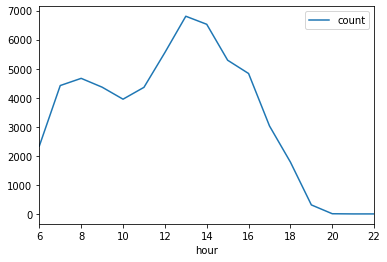

In [11]:
b = pd.DataFrame(msr_features.hour.value_counts()).reset_index().sort_values(by='index')

b.columns = ['hour', 'count']

b.plot(x='hour', y='count')

## Possible feature for future websearches (currently not used: German names for months and weekdays)

In [12]:
german_months = {1:'Januar', 2:'Februar', 3:'März', 4:'April', 5:'Mai', 6:'Juni', 7:'Juli', 8:'August', 9:'September',
                10:'Oktober', 11:'November', 12:'Dezember'}

german_weekdays = {0:'Montag', 1:'Dienstag', 2:'Mittwoch',3:'Donnerstag',4:'Freitag', 5:'Samstag', 6:'Sonntag'}


msr_features['month_german'] = msr_features.month.apply(lambda x: german_months[x])
msr_features['weekday_german'] = msr_features.weekday.apply(lambda x: german_weekdays[x])



## Encode hours as daytimes: night, morning, afternoon, evening

In [13]:
def get_daytime(hour):
    if 0 <= hour < 6:
        return 'night'
    if 6 <= hour < 12:
        return 'morning'
    if 12 <= hour < 19:
        return 'afternoon'
    if 19 <= hour < 24:
        return 'evening'

msr_features['daytime'] = msr_features.hour.apply(lambda x: get_daytime(x))

## Add list of dates (n dates before the current date) as relevant time frame for social media (twitter)

In [245]:
def get_daydate(date_str):
    '''Returns shortened date string in the format %Y-%m-%d.'''
    
    d = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
       
    return str(datetime.datetime.strftime(d, '%Y-%m-%d'))

msr_features['day_date'] = msr_features.date.apply(lambda x: get_daydate(x))

day_tw_feat = msr_features[['day_date']].copy().drop_duplicates()

In [246]:
def get_reldates(day_date_str, num_days_before):
    '''Get datestrings for the given number of days before the current day. Includes the current day.'''
    
    d = datetime.datetime.strptime(day_date_str, '%Y-%m-%d')
    
    dates = [d - datetime.timedelta(days=i) for i in range(num_days_before+1)]
    
    return [str(datetime.datetime.strftime(d, '%Y-%m-%d')) for d in dates]

day_tw_feat['twitter_reldates'] = day_tw_feat.day_date.apply(lambda x: ', '.join(get_reldates(x, 2)))

In [247]:
day_tw_feat.head()

,day_date,twitter_reldates
0,2019-04-01,"2019-04-01, 2019-03-31, 2019-03-30"
245,2019-04-02,"2019-04-02, 2019-04-01, 2019-03-31"
773,2019-04-03,"2019-04-03, 2019-04-02, 2019-04-01"
1101,2019-04-05,"2019-04-05, 2019-04-04, 2019-04-03"
1348,2019-04-09,"2019-04-09, 2019-04-08, 2019-04-07"


## Load relevant twitter data

In [167]:
tw_df = pd.read_csv('twitter_data/all_tweets_relcols.csv')

In [168]:
tw_df.head()

,id,author,re_tweeter,text,hashtags,mentions,favorite_count,day_date
0,1001074611705057280,baselcommunity,NaN,I Basel!pic.twitter.com/spqBrYkXky,[],[],48,2018-05-28
1,1177675468780130304,baselcommunity,NaN,Sister Duo Deer Park Avenue Premiere Empowerin...,[],['@the'],1,2019-09-27
2,1175859833960050688,deerparkavenue,baselcommunity,Love these Sunday sessions! What’s your favour...,[],[],21,2019-09-22
3,1175359315785502721,drBachme,baselcommunity,"Ein #Dauerbrenner im #Strassenverkehr, auch in...","['#Dauerbrenner', '#Strassenverkehr', '#Basel'...",[],4,2019-09-21
4,1175073074510749697,FC_Basel_en,baselcommunity,| Our Round of 16 game in the @SchweizerCup ag...,"['#FCBasel1893', '#FCSLOFCB']","['@SchweizerCup', '@FCSLO1']",2,2019-09-20


## Match tweets to relevant dates

In [169]:
class RelevantDateTweetsFeats(object):
    def __init__(self, twitter_df):
        self.data = dict()
        self.twitter = twitter_df
        
    def get_day_tweets(self, day_date):
        if day_date in self.data:
            return self.data[day_date]
        else:
            rel_df = self.twitter[self.twitter['day_date'] == str(day_date)].copy()
            rel_df = rel_df[['author', 're_tweeter', 'text', 'hashtags', 'mentions', 'favorite_count']]

            self.data[day_date] = rel_df
            return rel_df
        
    def get_daterange_tweets(self, daterange_list):
        # pandas dataframe for the whole timerange
        daterange_df = pd.DataFrame()
        for date_day in daterange_list:
            daterange_df = daterange_df.append(self.get_day_tweets(date_day))
                                               
        daterange_info_columns = ['authors', 're_tweeters', 'tweets_text', 'hashtags', 'mentions', 'favorite_counts']
        b = daterange_df.astype('str').values.T.tolist()

        exclude = ['nan', '[]']
        data_dict = {c:[i.rstrip(']').lstrip('[') for i in b if i not in exclude] for c,b in zip(daterange_info_columns, b)}                                                                          
        return data_dict

reldate_twfeat = RelevantDateTweetsFeats(tw_df)
            

In [170]:
# match relevant date ranges from feature dataframe with the corresponding dates in the twitter dataframe

twfeat_values = day_tw_feat.twitter_reldates.apply(lambda x: reldate_twfeat.get_daterange_tweets(x.split(', ')))
twfeat_values

0        {'authors': ['deerparkavenue', 'baselcommunity...
245      {'authors': ['jsdBS', 'deerparkavenue', 'basel...
773      {'authors': ['baselcommunity', 'jsdBS', 'deerp...
1101     {'authors': ['baselcommunity', 'PastorsWife202...
1348     {'authors': ['baselcommunity', 'baselcommunity...
                               ...                        
54745    {'authors': ['BaselStadt', 'BaselStadt', 'base...
55365    {'authors': ['BaselStadt', 'BaselStadt', 'Base...
56067    {'authors': ['RheinTemp', 'RheinTemp', 'BaselS...
56810    {'authors': ['BaselStadt', 'BaselStadt', 'Base...
57535    {'authors': ['FC_Basel_en', 'FC_Basel_en', 'sc...
Name: twitter_reldates, Length: 106, dtype: object

In [173]:
# convert output into pandas dataframe and remove duplicate values in the same cell

tweet_info_df = pd.DataFrame.from_records(list(twfeat_values))

for c in tweet_info_df.columns:
    tweet_info_df[c] = tweet_info_df[c].apply(lambda x: list(set(x)))
    
print(tweet_info_df.shape)
tweet_info_df.head()

(106, 6)


,authors,re_tweeters,tweets_text,hashtags,mentions,favorite_counts
0,"[FC_Basel_en, baselcommunity, RheinTemp, deerp...",[baselcommunity],"[""Baselworld cooperates with Basel restaurants...","['#LoveBasel', '#Rugby', '#Basel', '#RFCBasel'...","['@SH_RugbyClub', '@KegMunich', '@amnesty_de',...","[6, 3, 13, 1, 11, 0]"
1,"[deerparkavenue, jsdBS, RheinTemp, baselcommun...",[baselcommunity],"[""Baselworld cooperates with Basel restaurants...","['#LoveBasel', '#Morgaehn']","['@KegMunich', '@amnesty_de']","[3, 13, 0, 1]"
2,"[deerparkavenue, jsdBS, baselcommunity]",[baselcommunity],"[""Baselworld cooperates with Basel restaurants...",[],"['@KegMunich', '@amnesty_de']","[3, 13, 0, 1]"
3,"[PastorsWife2020, jsdBS, BergliBooks, baselcom...",[baselcommunity],[Can Swiss Currency be Counterfeited? Read Ber...,"['#lovebasel', '#like', '#FF', '#FollowFriday'...",['@baselcommunity'],"[4, 2, 3, 1, 10, 11, 0]"
4,[baselcommunity],[],[Deer Park Avenue with renowned literary agent...,[],[],"[3, 0, 1]"


In [274]:
# list of all place names with rubbish records
import re

# normalize and lower-case place names
place_names = [re.sub('basel, ', '', i.lower()) for i in list(msr_features.place_name.unique())]
place_names = [i for i in list(set(place_names)) if i]

len(place_names)

with open('places.txt', 'w') as p_f:
    for pl in place_names:
        p_f.write(pl + '\n')

### Add Twitter feature: record mentions of place names in tweets

In [257]:
tweet_info_df['tweets_text_lower'] = tweet_info_df.tweets_text.apply(lambda x: [i.lower() for i in x])

place_mention = tweet_info_df['tweets_text_lower'].apply(lambda x: [i for i in place_names if i in ' '.join(x)])

place_tuples = place_mention.apply(lambda x: tuple(set(x)))

tweet_info_df['tw_place_mentions'] = place_tuples

tweet_info_df.tw_place_mentions.value_counts()


day_tw_feat['tw_place_mentions'] = list(tweet_info_df['tw_place_mentions'])
day_tw_feat['tw_place_mentions'] = day_tw_feat.tw_place_mentions.apply(lambda x: ', '.join(x))

#distribution of place name mentions (counts of days)
day_tw_feat.tw_place_mentions.value_counts()

                                                                                                               61
klybeckstrasse                                                                                                  3
theater, erlenmatt                                                                                              3
hegenheimermattweg, bachgraben, breite                                                                          3
bundesplatz                                                                                                     2
horburgstrasse                                                                                                  2
wasgenring                                                                                                      2
rheingasse                                                                                                      2
aeschenplatz                                                                            

In [287]:
hash_lower = tweet_info_df['hashtags'].apply(lambda x: list(set([i.lower() for i in x])))
#hash_lower = hash_lower.apply(lambda x: type(x))
#[item for sublist in hash_lower for item in sublist]

hash_lower = hash_lower.apply(pd.Series).stack().reset_index(drop=True)

hash_lower = hash_lower.apply(lambda x: x.split(', '))

hash_lower = hash_lower.apply(pd.Series).stack().reset_index(drop=True)

hash_lower.unique()

array(["'#rugby'", "'#basel'", "'#rfcbasel'", "'#lovebasel'",
       "'#fcbasel1893'", "'#fclfcb'", "'#morgaehn'", "'#coffee'",
       "'#snow'", "'#rain'", "'#cold'", "'#fridaymotivation'",
       "'#flashbackfriday'", "'#followfriday'", "'#like'", "'#ff'",
       "'#community'", "'#international'", "'#munichsessions'",
       "'#cappuccino'", "'#fcz'", "'#fczuerich'", "'#stadtclub'",
       "'#easter'", "'#happyeastersunday'", "'#rotblaulive'",
       "'#kantonspolizei'", "'#fcsgfcb'", "'#giverny'", "'#gardens'",
       "'#travel'", "'#jachat'", "'#munich'", "'#salzburg'", "'#lugano'",
       "'#fcbfcz'", "'#royalbaby'", "'#rhein'", "'#swissguards'",
       "'#vatican'", "'#biggquotes'", "'#redcrossday'",
       "'#redcrescentday'", "'#switzerland'", "'#happymothersday'",
       "'#arbeitsunfall'", "'#riehen'", "'#openhouseworldwide'",
       "'#warteck'", "'#internationalmuseumday'", "'#fifaworldmuseum'",
       "'#rettung'", "'#spalentor'", "'#cups13ger'", "'#fcbthu'",
       "'#hs

In [153]:
msr_features.head()

,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,day,weekday,month,year,month_german,weekday_german,daytime,twitter_reldates
0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,1,0,4,2019,April,Montag,morning,"2019-04-01, 2019-03-31, 2019-03-30"
1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,1,0,4,2019,April,Montag,morning,"2019-04-01, 2019-03-31, 2019-03-30"
2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,1,0,4,2019,April,Montag,morning,"2019-04-01, 2019-03-31, 2019-03-30"
3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,1,0,4,2019,April,Montag,morning,"2019-04-01, 2019-03-31, 2019-03-30"
4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,1,0,4,2019,April,Montag,morning,"2019-04-01, 2019-03-31, 2019-03-30"


In [ ]:
#number tweets
#texts tweets
#authors 
#all hashtags
#all mentions
#all favority counts

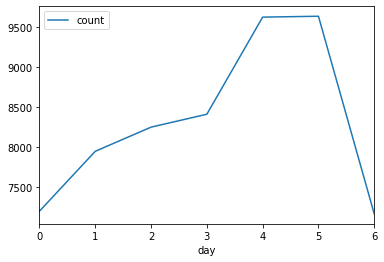

In [275]:
weekday_dist = pd.DataFrame(msr_features.weekday.value_counts()).reset_index()
weekday_dist.columns = ['day', 'count']

weekday_dist = weekday_dist.sort_values(by='day')

weekday_dist.plot(x='day', y='count')


## Save features to file

In [ ]:
# save feature to file
msr_features.to_csv('2019-09-27-basel-measures-FEAT.csv', index=None)